In [1]:
import numpy as np
import symengine as spe
import matplotlib.pyplot as plt
import csv
import sympy
import copy
import torch
from utils import *
import matplotlib as mpl
#mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
t = spe.symbols('t')
exec(open("../GODE/scipy_solver.py").read())
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sympy.Number)})

# LODE

In [3]:
# Load the data
DATA_TYPE = 'data_noisy'
noise_sigma = 0.05
all_noisy_data = []
all_true_data = []
all_gvae_data = []
all_pysr_data = []
all_pysr2_data = []
all_proged_data = []
all_odeformer_data = []
num_lode = 0
for i in range(1,6): #[3,5]
    case = str(i)
    exec(open("../GODE/examples/ode"+case+".py").read())
    print(true_eq)
    t_val = np.linspace(t_low, t_high + 1 / fs, int((t_high - t_low) * fs + 1))
    u = sympy.sympify(true_solution[0])
    t = sympy.symbols('t')
    u_sym = sympy.lambdify((t), u, modules='numpy')
    u_val = u_sym(t_val)
    if type(u_val) != np.ndarray:
        u_val = u_val*np.ones(t_val.shape)
    dudt_sym = sympy.lambdify((t), sympy.diff(u, t), modules='numpy')
    dudt_val = dudt_sym(t_val)
    if type(dudt_val) != np.ndarray:
        dudt_val = dudt_val*np.ones(t_val.shape)
    true_sol = np.concatenate((np.expand_dims(t_val, axis=1), np.expand_dims(u_val, axis=1), np.expand_dims(dudt_val, axis=1)), axis=1)
    if ORDER == 2:
        d2udt2_sym = sympy.lambdify((t), sympy.diff(sympy.diff(u,t), t), modules='numpy')
        d2udt2_val = d2udt2_sym(t_val)
        if type(d2udt2_val) != np.ndarray:
            d2udt2_val = d2udt2_val*np.ones(t_val.shape)
        true_sol = np.concatenate((true_sol, np.expand_dims(d2udt2_val.T, axis=1)), axis=1)
    all_true_data.append([true_eq, true_sol, ORDER])
    # Generate noisy data
    u_mean = np.mean(true_sol[:,1], axis = 0)
    u_std = np.sqrt(np.sum((true_sol[:,1] - u_mean)**2/true_sol[:,0].shape[0], axis = 0))
    # measured data points, last excluded, as it's included for plotting
    u_noisy = torch.tensor(true_sol[:-1,1] + noise_sigma*np.random.randn(*true_sol[:-1,1].shape)*u_std).float().view(-1, 1)
    all_noisy_data.append(u_noisy)
    # GVAE result
    curr_loss = 1e6
    curr_eq = ''
    gvae_sol = None
    print('Start GVAE')
    #GVAE Benchmark 2
    with open('GODE_results/Output_B2_n5_ODE'+case+'_ls26_2S_SMSE.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            _, eq, loss = row
            try:
                try:
                    curr_sol = solve_ode(eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                except:
                    curr_sol = solve_implicit_ode(eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                if curr_loss > float(loss):
                    curr_loss = float(loss)
                    curr_eq = eq
                    gvae_sol = curr_sol
            except:
                continue
            k += 1
    all_gvae_data.append([curr_eq, gvae_sol])
    print('End GVAE')
    # PySR results
    curr_loss = 1e6
    curr_eq = ''
    with open('Others_results/PySR/Output_B2_pySR_ODE'+case+'_best.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            if float(loss) < curr_loss:
                curr_loss = float(loss)
                curr_eq = eq
            k += 1
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    pysr_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_pysr_data.append([add_on+curr_eq, pysr_sol])
    # PySR - SCORE results
    curr_loss = 1e6
    curr_eq = ''
    with open('Others_results/PySR/Output_B2_pySR_ODE'+case+'_score.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            if float(loss) < curr_loss:
                curr_loss = float(loss)
                curr_eq = eq
            k += 1
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    pysr2_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_pysr2_data.append([add_on+curr_eq, pysr2_sol])
    # ProGED results
    curr_loss = 1e6
    curr_eq = ''
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    with open('Others_results/ProGED/Output_B2_ProGED_ODE'+case+'_best.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            eqs = eq.split(',')
            if ORDER == 1:
                eq = eqs[1][:-1].replace('x0', 'u')
            else:
                eq = eqs[2][:-1].replace('x0', 'u')
                #print(eq)
            eq = eq.replace('x1', 'diff(u,t)')
            try:
                curr_sol = solve_ode(add_on+eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                if float(loss) < curr_loss:
                    curr_loss = float(loss)
                    curr_eq = eq
            except:
                continue
            k += 1
    proged_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_proged_data.append([add_on+curr_eq, proged_sol])
    num_lode += 1

diff(u,t)+u/t-2
Start GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
End GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
diff(u,t)+u*cos(t)/sin(t)-1/sin(t)
Start GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
End GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
diff(u,t)+u/5-exp(t/-5)*cos(t)
Start GVAE
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
End GVAE
Successfully solved O

# NLODE

In [4]:
for i in range(1,6):
    case = str(i)
    exec(open("../GODE/examples/nlode"+case+".py").read())
    print(true_eq)
    t_val = np.linspace(t_low, t_high + 1 / fs, int((t_high - t_low) * fs + 1))
    u = sympy.sympify(true_solution[0])
    t = sympy.symbols('t')
    if ORDER == 1:
        eq = sympy.lambdify((t), [u, sympy.diff(u, t)], modules='numpy')
    else:
        eq = sympy.lambdify((t), [u, sympy.diff(u, t), sympy.diff(u, t, t)], modules='numpy')
    true_sol = np.concatenate((np.expand_dims(t_val, axis=1), np.array(eq(t_val)).T), axis=1)
    all_true_data.append([true_eq, true_sol, ORDER])
    # Generate noisy data
    u_mean = np.mean(true_sol[:,1], axis = 0)
    u_std = np.sqrt(np.sum((true_sol[:,1] - u_mean)**2/true_sol[:,0].shape[0], axis = 0))
    # measured data points, last excluded, as it's included for plotting
    u_noisy = torch.tensor(true_sol[:-1,1] + noise_sigma*np.random.randn(*true_sol[:-1,1].shape)*u_std).float().view(-1, 1)
    all_noisy_data.append(u_noisy)
    # GVAE result
    curr_loss = 1e6
    curr_eq = ''
    gvae_sol = None
    #GVAE Benchmark 2
    with open('GODE_results/Output_B2_n5_NLODE'+case+'_ls26_2S_SMSE.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            _, eq, loss = row
            try:
                try:
                    curr_sol = solve_ode(eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False) #1/((t_high-t_low)/(n_sample-1)),
                except:
                    curr_sol = solve_implicit_ode(eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False) #1/((t_high-t_low)/(n_sample-1)),

                if curr_loss > float(loss):
                    curr_loss = float(loss)
                    curr_eq = eq
                    gvae_sol = curr_sol
            except:
                continue
            k += 1
    all_gvae_data.append([curr_eq, gvae_sol])
    # PySR results
    curr_loss = 1e6
    curr_eq = ''
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    with open('Others_results/PySR/Output_B2_pySR_NLODE'+case+'_best.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            try: 
                if float(loss) < curr_loss:
                    pysr_sol = solve_ode(add_on+eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                    curr_loss = float(loss)
                    curr_eq = eq
            except:
                continue
            k += 1
    pysr_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_pysr_data.append([add_on+curr_eq, pysr_sol])
    # PySR - SCORE results
    curr_loss = 1e6
    curr_eq = ''
    with open('Others_results/PySR/Output_B2_pySR_NLODE'+case+'_score.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            if float(loss) < curr_loss:
                curr_loss = float(loss)
                curr_eq = eq
            k += 1
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    pysr2_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_pysr2_data.append([add_on+curr_eq, pysr2_sol])
    # ProGED results
    curr_loss = 1e6
    curr_eq = ''
    if ORDER == 1:
        add_on = '-diff(u,t)+'
    else:
        add_on = '-diff(diff(u,t),t)+'
    with open('Others_results/ProGED/Output_B2_ProGED_NLODE'+case+'_best.csv', mode = 'r') as csvfile:
        csv_read = csv.reader(csvfile)
        k = 0
        for row in csv_read:
            if k == 0:
                k += 1
                continue
            eq, loss = row
            eqs = eq.split(',')
            if ORDER == 1:
                eq = eqs[1][:-1].replace('x0', 'u')
            else:
                eq = eqs[2][:-1].replace('x0', 'u')
            eq = eq.replace('x1', 'diff(u,t)')
            try:
                curr_sol = solve_ode(add_on+eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
                if float(loss) < curr_loss:
                    curr_loss = float(loss)
                    curr_eq = eq
            except:
                continue
            k += 1
    proged_sol = solve_ode(add_on+curr_eq, t_low, t_high, fs = fs, y0=y0, order = ORDER, CHECK_SUCCESS = False)
    all_proged_data.append([add_on+curr_eq, proged_sol])

diff(u,t)+-1/(2*u)-0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
diff(diff(u,t),t)*diff(u,t)*1--4/t^3
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! -1


<lambdifygenerated-102>:2: RuntimeWarning: invalid value encountered in scalar power
  return [-0.41980159*((v**t - sin(sin(u)))**(t**v))**t - 0.626535905566948]
<lambdifygenerated-109>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return [-1470.27940767066 + 1949.43285518673/u]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:112: RuntimeWarning: invalid value encountered in multiply
  y1 = y0 + h0 * direction * f0
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:114: RuntimeWarning: invalid value encountered in subtract
  d2 = norm((f1 - f0) / scale) / h0


Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! -1
Successfully solved ODE! 0
diff(diff(u,t),t)*t^2+diff(u,t)*diff(u,t)*t^2--1/log(t)
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0


<lambdifygenerated-118>:2: RuntimeWarning: invalid value encountered in scalar divide
  return [sin(0.74442595*(v - cos(cos(t - 1.72850437132586)))*sin(u)*sin(v)/u)]


Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
diff(diff(u,t),t)^2+-81*u^2-0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
diff(diff(u,t),t)*diff(u,t)+-2.1*u-9.84*t^3
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successfully solved ODE! 0
Successf

# Results plot

In [5]:
def getR2(true, pred):
    true = np.array(true) # remove last one, as it's included for plotting only
    pred = np.array(pred)
    return 1 - np.sum((true - pred)**2)/np.sum((true - np.mean(true))**2)

def getrelL2Error(true, pred):
    true = np.array(true) # remove last one, as it's included for plotting only
    pred = np.array(pred)
    return np.sqrt(np.sum((true - pred)**2))/np.sqrt(np.sum((true)**2))

In [6]:
# initialise lists
R2_dict = dict()
L2_dict = dict()
label = ['pysr', 'pysr2', 'proged', 'gvae'] 
for l in label:
    R2_dict[l] = []
    L2_dict[l] = []
# save 1st R2 for u(t), 2nd R2 for u'(t)

In [7]:
for i in range(0, 10): 
    true_u = all_true_data[i][1][:,1].flatten()
    true_du = all_true_data[i][1][:,2].flatten()
    if all_true_data[i][2] == 2:
        true_d2u = all_true_data[i][1][:,3].flatten()
    for l in label:
        pred_u = locals()[f"all_{l}_data"][i][1][1].flatten()
        pred_du = locals()[f"all_{l}_data"][i][1][2].flatten()
        if all_true_data[i][2] == 2:
            pred_d2u = locals()[f"all_{l}_data"][i][1][3].flatten()
            R2_dict[l].append([getR2(true_u, pred_u), getR2(true_du, pred_du), getR2(true_d2u, pred_d2u)])
            L2_dict[l].append([getrelL2Error(true_u, pred_u), getrelL2Error(true_du, pred_du), getrelL2Error(true_d2u, pred_d2u)])
        else:
            R2_dict[l].append([getR2(true_u, pred_u), getR2(true_du, pred_du)])
            L2_dict[l].append([getrelL2Error(true_u, pred_u), getrelL2Error(true_du, pred_du)])

In [8]:
mean_L2_dict = dict()
mean_L2_dict_NLODE = dict()
copy_L2_dict = copy.deepcopy(L2_dict)
for l in label:
    mean_L2_dict[l] = [0,0,0]
    mean_L2_dict_NLODE[l] = [0,0,0]
    for i in range(len(copy_L2_dict[l])):
        copy_L2_dict[l][i] = np.array(copy_L2_dict[l][i])
        print(l, np.sum(copy_L2_dict[l][i] > 1))
        copy_L2_dict[l][i][copy_L2_dict[l][i] > 1] = 1
        for j in range(len(copy_L2_dict[l][i])):
            mean_L2_dict[l][j] += copy_L2_dict[l][i][j]
        if i >= 5:
            for j in range(len(copy_L2_dict[l][i])):
                mean_L2_dict_NLODE[l][j] += copy_L2_dict[l][i][j]
    mean_L2_dict[l][0] /= 10
    mean_L2_dict[l][1] /= 10
    mean_L2_dict[l][2] /= 6
    mean_L2_dict_NLODE[l][0] /= 5
    mean_L2_dict_NLODE[l][0] /= 5
    mean_L2_dict_NLODE[l][0] /= 4

pysr 0
pysr 0
pysr 0
pysr 0
pysr 0
pysr 0
pysr 0
pysr 0
pysr 0
pysr 1
pysr2 0
pysr2 0
pysr2 0
pysr2 0
pysr2 0
pysr2 0
pysr2 0
pysr2 0
pysr2 0
pysr2 0
proged 0
proged 0
proged 0
proged 3
proged 0
proged 0
proged 1
proged 1
proged 2
proged 0
gvae 0
gvae 0
gvae 0
gvae 0
gvae 0
gvae 0
gvae 0
gvae 0
gvae 0
gvae 0


In [9]:
# results table 2
mean_L2_dict

{'pysr': [0.11513803611914326, 0.14461343080504738, 0.37945458173247176],
 'pysr2': [0.14302701677490512, 0.1356761079749958, 0.36340743515478],
 'proged': [0.32622831441680605, 0.40550791608441744, 0.8106273284943009],
 'gvae': [0.120199067401499, 0.13304840247163852, 0.1871383743653822]}

In [10]:
res_selected = [0,3,5,6,9]
app_selected = list(set([0,1,2,3,4,5,6,7,8,9])-set(res_selected))

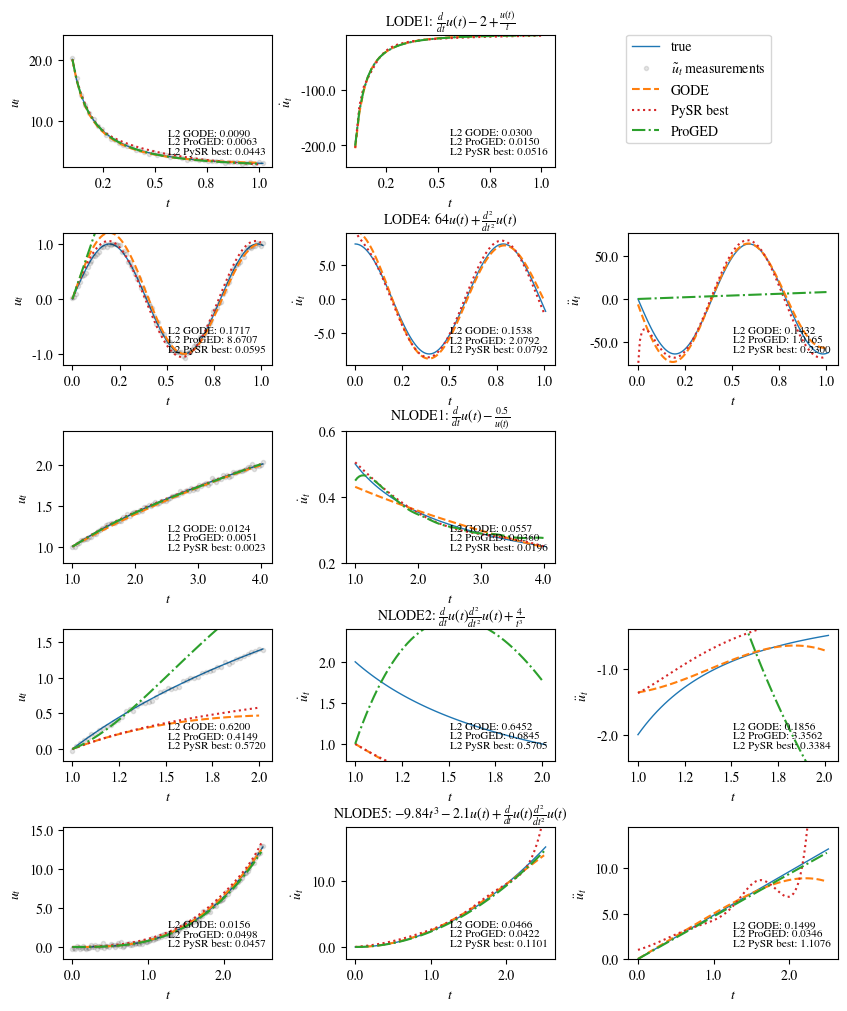

In [11]:
# Figure for results 
mpl.rc('font', family = 'Times')
mpl.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(len(res_selected),3, figsize=(10,12))
t = sympy.symbols('t')
for i in range(len(res_selected)):
    r = i
    order = all_true_data[res_selected[i]][2]
    # true values
    axs[r,0].plot(all_true_data[res_selected[i]][1][:,0], np.array(all_true_data[res_selected[i]][1][:,1]).flatten(), color = 'tab:blue', linewidth = 1, label = '_nolegend_' if i < 4 else 'true')
    axs[r,1].plot(all_true_data[res_selected[i]][1][:,0], np.array(all_true_data[res_selected[i]][1][:,2]).flatten(), color = 'tab:blue', linewidth = 1, label = '_nolegend_' if i < 5 else r"$\dot{u}_t$" +', true')
    ylim_min_u = min(np.array(all_true_data[res_selected[i]][1][:,1]).flatten())
    ylim_max_u = max(np.array(all_true_data[res_selected[i]][1][:,1]).flatten())
    ylim_min_du = min(np.array(all_true_data[res_selected[i]][1][:,2]).flatten())
    ylim_max_du = max(np.array(all_true_data[res_selected[i]][1][:,2]).flatten())
    if order == 2:
        axs[r,2].plot(all_true_data[res_selected[i]][1][:,0], np.array(all_true_data[res_selected[i]][1][:,3]).flatten(), color = 'tab:blue', linewidth = 1, label = '_nolegend_' if i < 5 else r"$\ddot{u}_t$" +', true')
        ylim_min_d2u = min(np.array(all_true_data[res_selected[i]][1][:,3]).flatten())
        ylim_max_d2u = max(np.array(all_true_data[res_selected[i]][1][:,3]).flatten())
        ylim_min_d2u = 1.2*ylim_min_d2u if ylim_min_d2u < 0 else 0.8*ylim_min_d2u
        ylim_max_d2u = 0.8*ylim_max_d2u if ylim_max_d2u < 0 else 1.2*ylim_max_d2u
    ylim_min_u = 1.2*ylim_min_u if ylim_min_u < 0 else 0.8*ylim_min_u
    ylim_max_u = 0.8*ylim_max_u if ylim_max_u < 0 else 1.2*ylim_max_u
    ylim_min_du = 1.2*ylim_min_du if ylim_min_du < 0 else 0.8*ylim_min_du
    ylim_max_du = 0.8*ylim_max_du if ylim_max_du < 0 else 1.2*ylim_max_du
    ylim_min_u = ylim_min_u-(0.1*(ylim_max_u-ylim_min_u)) if ylim_min_u == 0 else ylim_min_u
    ylim_min_du = ylim_min_du-(0.1*(ylim_max_du-ylim_min_du)) if ylim_min_du == 0 else ylim_min_du
    ylim_max_u = ylim_max_u+(0.1*(ylim_max_u-ylim_min_u)) if ylim_max_u == 0 else ylim_max_u
    ylim_max_du = ylim_max_du+(0.1*(ylim_max_du-ylim_min_du)) if ylim_max_du == 0 else ylim_max_du
    # measurements
    u_mean = np.mean(all_true_data[res_selected[i]][1][:,1], axis = 0)
    u_std = np.sqrt(np.sum((all_true_data[res_selected[i]][1][:,1] - u_mean)**2/all_true_data[res_selected[i]][1][:,0].shape[0], axis = 0))
    # measured data points
    u_val_noisy = torch.tensor(all_true_data[res_selected[i]][1][:,1] + noise_sigma*np.random.randn(*all_true_data[res_selected[i]][1][:,1].shape)*u_std).float().view(-1, 1)
    axs[r,0].plot(all_true_data[res_selected[i]][1][:,0], u_val_noisy, '.', alpha = 0.1, color = 'k', label = '_nolegend_' if i < 4 else r"$\tilde{u}_t$"+' measurements')
    # plot GVAE predictions
    axs[r,0].plot(all_gvae_data[res_selected[i]][1][0], np.array(all_gvae_data[res_selected[i]][1][1]).flatten(), '--', color = 'tab:orange', label = '_nolegend_' if i < 4 else 'GODE')
    axs[r,1].plot(all_gvae_data[res_selected[i]][1][0], np.array(all_gvae_data[res_selected[i]][1][2]).flatten(), '--', color = 'tab:orange', label = '_nolegend_' if i < 5 else r"$\hat{\dot{u}}_t$" +', GVAE')
    if order == 2:
        axs[r,2].plot(all_gvae_data[res_selected[i]][1][0], np.array(all_gvae_data[res_selected[i]][1][3]).flatten(), '--',color = 'tab:orange', label = '_nolegend_' if i < 5 else r"$\hat{\ddot{u}}_t$" +', GVAE')
    # plot PySR predictions
    axs[r,0].plot(all_pysr_data[res_selected[i]][1][0], np.array(all_pysr_data[res_selected[i]][1][1]).flatten(), ':', color = 'tab:red', label = '_nolegend_' if i < 4 else 'PySR best')
    axs[r,1].plot(all_pysr_data[res_selected[i]][1][0], np.array(all_pysr_data[res_selected[i]][1][2]).flatten(), ':', color = 'tab:red', label = '_nolegend_' if i < 5 else r"$\hat{\dot{u}}_t$" +', PySR best')
    if order == 2:
        axs[r,2].plot(all_pysr_data[res_selected[i]][1][0], np.array(all_pysr_data[res_selected[i]][1][3]).flatten(), ':',color = 'tab:red', label = '_nolegend_' if i < 5 else r"$\hat{\ddot{u}}_t$" +', PySR best')
    # plot ProGED predictions
    axs[r,0].plot(all_proged_data[res_selected[i]][1][0], np.array(all_proged_data[res_selected[i]][1][1]).flatten(), '-.', color = 'tab:green', label = '_nolegend_' if i < 4 else 'ProGED')
    axs[r,1].plot(all_proged_data[res_selected[i]][1][0], np.array(all_proged_data[res_selected[i]][1][2]).flatten(), '-.', color = 'tab:green', label = '_nolegend_' if i < 5 else r"$\hat{\dot{u}}_t$" +', ProGED')
    if order == 2:
        axs[r,2].plot(all_proged_data[res_selected[i]][1][0], np.array(all_proged_data[res_selected[i]][1][3]).flatten(), '-.',color = 'tab:green', label = '_nolegend_' if i < 5 else r"$\hat{\ddot{u}}_t$" +', ProGED')
    # text
    math_expr = all_true_data[res_selected[i]][0][:]
    math_expr = math_expr.replace('^', '**')
    math_expr = math_expr.replace('u', 'u(t)')
    math_expr = sympy.simplify(sympy.sympify(math_expr))
    math_expr = round_expr(math_expr,2)
    math_eq = sympy.latex(math_expr) 
    for j in range(3):
        axs[r,j].text(0.50,0.1,'L2 PySR best: {:.4f}'.format(L2_dict['pysr'][res_selected[i]][j]), transform=axs[r,j].transAxes, fontsize = 8)
        axs[r,j].text(0.50,0.17,'L2 ProGED: {:.4f}'.format(L2_dict['proged'][res_selected[i]][j]), transform=axs[r,j].transAxes, fontsize = 8)
        axs[r,j].text(0.50,0.24,'L2 GODE: {:.4f}'.format(L2_dict['gvae'][res_selected[i]][j]), transform=axs[r,j].transAxes, fontsize = 8)
        axs[r,j].set_xlabel(r'$t$', fontsize=10)
        if order <= j:
            break
    if res_selected[i] < num_lode:
        axs[r,1].set_title('LODE'+str(res_selected[i]+1)+f": ${math_eq}$", fontsize=10)
    else:
        axs[r,1].set_title('NLODE'+str(res_selected[i]-num_lode+1)+f": ${math_eq}$", fontsize=10)
    #plt.xlabel('t', fontsize = 10)
    axs[r,0].set_ylim([ylim_min_u, ylim_max_u])
    axs[r,1].set_ylim([ylim_min_du, ylim_max_du])
    if order == 2:
        axs[r,2].set_ylim([ylim_min_d2u, ylim_max_d2u])
        axs[r,2].set_ylabel(r'$\ddot{u}_t$', fontsize=10)
    axs[r,0].set_ylabel(r'$u_t$', fontsize=10)
    axs[r,1].set_ylabel(r'$\dot{u}_t$', fontsize=10)
    if order == 1:
        fig.delaxes(axs[i,2])
    axs[r,0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,0].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,2].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
fig.legend(loc='right', bbox_to_anchor=(0.84, 0.835), ncols = 1, fontsize = 10)
plt.subplots_adjust(hspace=0.5, wspace = 0.35)
#plt.savefig('B2_Results_Selected_2S.png', dpi = 600, bbox_inches = 'tight')

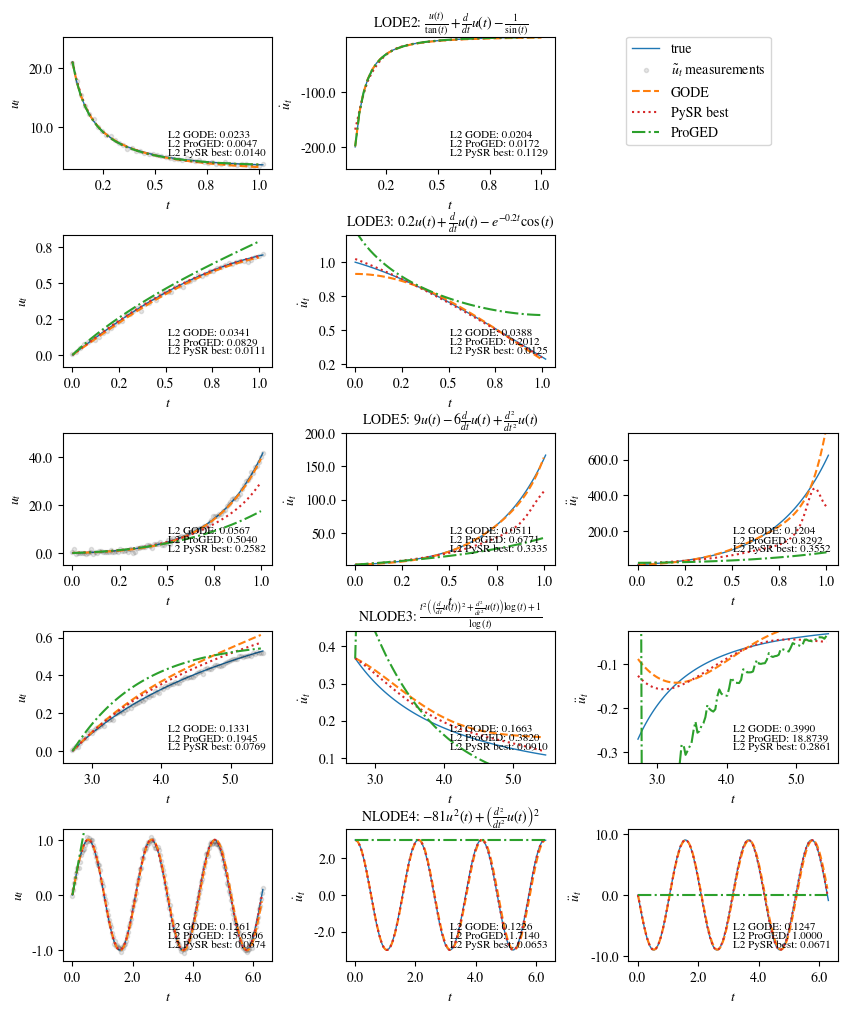

In [12]:
# Figure for results
mpl.rc('font', family = 'Times')
mpl.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(len(app_selected),3, figsize=(10,12))
t = sympy.symbols('t')
for i in range(len(app_selected)):
    r = i
    order = all_true_data[app_selected[i]][2]
    # true values
    axs[r,0].plot(all_true_data[app_selected[i]][1][:,0], np.array(all_true_data[app_selected[i]][1][:,1]).flatten(), color = 'tab:blue', linewidth = 1, label = '_nolegend_' if i < 4 else 'true')
    axs[r,1].plot(all_true_data[app_selected[i]][1][:,0], np.array(all_true_data[app_selected[i]][1][:,2]).flatten(), color = 'tab:blue', linewidth = 1, label = '_nolegend_' if i < 6 else r"$\dot{u}_t$" +', true')
    ylim_min_u = min(np.array(all_true_data[app_selected[i]][1][:,1]).flatten())
    ylim_max_u = max(np.array(all_true_data[app_selected[i]][1][:,1]).flatten())
    ylim_min_du = min(np.array(all_true_data[app_selected[i]][1][:,2]).flatten())
    ylim_max_du = max(np.array(all_true_data[app_selected[i]][1][:,2]).flatten())
    if order == 2:
        axs[r,2].plot(all_true_data[app_selected[i]][1][:,0], np.array(all_true_data[app_selected[i]][1][:,3]).flatten(), color = 'tab:blue', linewidth = 1, label = '_nolegend_' if i < 6 else r"$\ddot{u}_t$" +', true')
        ylim_min_d2u = min(np.array(all_true_data[app_selected[i]][1][:,3]).flatten())
        ylim_max_d2u = max(np.array(all_true_data[app_selected[i]][1][:,3]).flatten())
        ylim_min_d2u = 1.2*ylim_min_d2u if ylim_min_d2u < 0 else 0.8*ylim_min_d2u
        ylim_max_d2u = 0.8*ylim_max_d2u if ylim_max_d2u < 0 else 1.2*ylim_max_d2u
    ylim_min_u = 1.2*ylim_min_u if ylim_min_u < 0 else 0.8*ylim_min_u
    ylim_max_u = 0.8*ylim_max_u if ylim_max_u < 0 else 1.2*ylim_max_u
    ylim_min_du = 1.2*ylim_min_du if ylim_min_du < 0 else 0.8*ylim_min_du
    ylim_max_du = 0.8*ylim_max_du if ylim_max_du < 0 else 1.2*ylim_max_du
    ylim_min_u = ylim_min_u-(0.1*(ylim_max_u-ylim_min_u)) if ylim_min_u == 0 else ylim_min_u
    ylim_min_du = ylim_min_du-(0.1*(ylim_max_du-ylim_min_du)) if ylim_min_du == 0 else ylim_min_du
    ylim_min_d2u = ylim_min_d2u-(0.1*(ylim_max_d2u-ylim_min_d2u)) if ylim_min_d2u == 0 else ylim_min_d2u
    ylim_max_u = ylim_max_u+(0.1*(ylim_max_u-ylim_min_u)) if ylim_max_u == 0 else ylim_max_u
    ylim_max_du = ylim_max_du+(0.1*(ylim_max_du-ylim_min_du)) if ylim_max_du == 0 else ylim_max_du
    # measurements
    u_mean = np.mean(all_true_data[app_selected[i]][1][:,1], axis = 0)
    u_std = np.sqrt(np.sum((all_true_data[app_selected[i]][1][:,1] - u_mean)**2/all_true_data[app_selected[i]][1][:,0].shape[0], axis = 0))
    # measured data points
    u_val_noisy = torch.tensor(all_true_data[app_selected[i]][1][:,1] + noise_sigma*np.random.randn(*all_true_data[app_selected[i]][1][:,1].shape)*u_std).float().view(-1, 1)
    axs[r,0].plot(all_true_data[app_selected[i]][1][:,0], u_val_noisy, '.', alpha = 0.1, color = 'k', label = '_nolegend_' if i < 4 else r"$\tilde{u}_t$"+' measurements')
    # plot GVAE predictions
    axs[r,0].plot(all_gvae_data[app_selected[i]][1][0], np.array(all_gvae_data[app_selected[i]][1][1]).flatten(), '--', color = 'tab:orange', label = '_nolegend_' if i < 4 else 'GODE')
    axs[r,1].plot(all_gvae_data[app_selected[i]][1][0], np.array(all_gvae_data[app_selected[i]][1][2]).flatten(), '--', color = 'tab:orange', label = '_nolegend_' if i < 6 else r"$\hat{\dot{u}}_t$" +', GVAE')
    if order == 2:
        axs[r,2].plot(all_gvae_data[app_selected[i]][1][0], np.array(all_gvae_data[app_selected[i]][1][3]).flatten(), '--',color = 'tab:orange', label = '_nolegend_' if i < 6 else r"$\hat{\ddot{u}}_t$" +', GVAE')
    # plot PySR predictions
    axs[r,0].plot(all_pysr_data[app_selected[i]][1][0], np.array(all_pysr_data[app_selected[i]][1][1]).flatten(), ':', color = 'tab:red', label = '_nolegend_' if i < 4 else 'PySR best')
    axs[r,1].plot(all_pysr_data[app_selected[i]][1][0], np.array(all_pysr_data[app_selected[i]][1][2]).flatten(), ':', color = 'tab:red', label = '_nolegend_' if i < 6 else r"$\hat{\dot{u}}_t$" +', PySR best')
    if order == 2:
        axs[r,2].plot(all_pysr_data[app_selected[i]][1][0], np.array(all_pysr_data[app_selected[i]][1][3]).flatten(), ':',color = 'tab:red', label = '_nolegend_' if i < 6 else r"$\hat{\ddot{u}}_t$" +', PySR best')
    # plot ProGED predictions
    axs[r,0].plot(all_proged_data[app_selected[i]][1][0], np.array(all_proged_data[app_selected[i]][1][1]).flatten(), '-.', color = 'tab:green', label = '_nolegend_' if i < 4 else 'ProGED')
    axs[r,1].plot(all_proged_data[app_selected[i]][1][0], np.array(all_proged_data[app_selected[i]][1][2]).flatten(), '-.', color = 'tab:green', label = '_nolegend_' if i < 6 else r"$\hat{\dot{u}}_t$" +', ProGED')
    if order == 2:
        axs[r,2].plot(all_proged_data[app_selected[i]][1][0], np.array(all_proged_data[app_selected[i]][1][3]).flatten(), '-.',color = 'tab:green', label = '_nolegend_' if i < 6 else r"$\hat{\ddot{u}}_t$" +', ProGED')
    
    # text
    math_expr = all_true_data[app_selected[i]][0][:]
    math_expr = math_expr.replace('^', '**')
    math_expr = math_expr.replace('u', 'u(t)')
    math_expr = sympy.simplify(sympy.sympify(math_expr))
    math_expr = round_expr(math_expr,2)
    math_eq = sympy.latex(math_expr) 
    for j in range(3):
        axs[r,j].text(0.50,0.1,'L2 PySR best: {:.4f}'.format(L2_dict['pysr'][app_selected[i]][j]), transform=axs[r,j].transAxes, fontsize = 8)
        axs[r,j].text(0.50,0.17,'L2 ProGED: {:.4f}'.format(L2_dict['proged'][app_selected[i]][j]), transform=axs[r,j].transAxes, fontsize = 8)
        axs[r,j].text(0.50,0.24,'L2 GODE: {:.4f}'.format(L2_dict['gvae'][app_selected[i]][j]), transform=axs[r,j].transAxes, fontsize = 8)
        axs[r,j].set_xlabel(r'$t$', fontsize=10)
        if order <= j:
            break
    if app_selected[i] < num_lode:
        axs[r,1].set_title('LODE'+str(app_selected[i]+1)+f": ${math_eq}$", fontsize=10)
    else:
        axs[r,1].set_title('NLODE'+str(app_selected[i]-num_lode+1)+f": ${math_eq}$", fontsize=10)
    axs[r,0].set_ylim([ylim_min_u, ylim_max_u])
    axs[r,1].set_ylim([ylim_min_du, ylim_max_du])
    if order == 2:
        axs[r,2].set_ylim([ylim_min_d2u, ylim_max_d2u])
        axs[r,2].set_ylabel(r'$\ddot{u}_t$', fontsize=10)
    axs[r,0].set_ylabel(r'$u_t$', fontsize=10)
    axs[r,1].set_ylabel(r'$\dot{u}_t$', fontsize=10)
    if order == 1:
        fig.delaxes(axs[i,2])
    axs[r,0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,0].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,1].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
    axs[r,2].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: '{:.1f}'.format(x)))
fig.legend(loc='right', bbox_to_anchor=(0.84, 0.835), ncols = 1, fontsize = 10)
plt.subplots_adjust(hspace=0.5, wspace = 0.35)
#plt.savefig('B2_Results_Appendix_2S.png', dpi = 600, bbox_inches = 'tight')

In [13]:
# Check complexity of all expressions
all_equations_tree = dict()
all_equations = dict()
all_complexity = dict()
label = ['true','pysr', 'pysr2','proged', 'gvae']
for l in label:
    all_equations_tree[l] = []
    all_equations[l] = []
    all_complexity[l] = []

In [14]:
weights = {
    "constant": 1,   # Weight for constants
    "variable": 1,   # Weight for variables
    "operation": 1,  # Weight for operations
}
def compute_complexity(expr):
    #print(expr, expr.args)
    if expr.is_Atom:  # Leaf nodes
        if expr.is_Number:
            #print(expr.is_Number, 'N', expr.args)
            return weights["constant"]
        elif expr.is_Symbol:
            #print(expr.is_Symbol, 'S', expr.args)
            return weights["variable"]
    # Operations or composite expressions
    #print('O')
    return weights["operation"] + sum(compute_complexity(arg) for arg in expr.args)

In [15]:
for i in range(0,10):
    for l in label:
        eq = locals()[f"all_{l}_data"][i][0]
        eq = eq.replace('u', 'u(t)')
        if l == 'gvae':
            expr = eq.replace('diff(diff(u(t),t),t)', 'd2u_dt2')
            expr = expr.replace('diff(u(t),t)', 'du_dt')
            expr = expr.replace('u(t)', 'u_t')
            eq = spe.sympify(expr).expand()#normalize_expr()
            eq = eq.replace('u_t', 'u(t)')
            eq = eq.replace('du_dt', 'Derivative(u,t)')
            eq = eq.replace('d2u_dt2', 'Derivative(Derivative(u,t),t)')
        eq = sympy.sympify(eq)
        eq = sympy.simplify(eq)
        all_equations_tree[l].append(sympy.srepr(eq))
        all_equations[l].append(str(eq))
        all_complexity[l].append(compute_complexity(eq))

In [16]:
for l in label: # complexity of table 2
    print(f"Mean complexity of {l} equations: {np.mean(np.array(all_complexity[l]))}")
    print(f"Mean normalized complexity of {l} equations: {np.mean(np.array(all_complexity[l]/np.array(all_complexity['true'])))}")

Mean complexity of true equations: 18.1
Mean normalized complexity of true equations: 1.0
Mean complexity of pysr equations: 29.5
Mean normalized complexity of pysr equations: 1.7377629654860776
Mean complexity of pysr2 equations: 18.3
Mean normalized complexity of pysr2 equations: 1.0373277142384694
Mean complexity of proged equations: 17.2
Mean normalized complexity of proged equations: 1.0127676175845512
Mean complexity of gvae equations: 15.7
Mean normalized complexity of gvae equations: 0.9011917487546779
